# 13. 결과 시각화

### t-SNE(t-distributed Stochastic Neighbor Embedding) 

실험이 완료되면 결과를 시각화 하는 것이 매우 중요하다. 하지만 이미지나 추출 된 피쳐들은 차원이 높기 때문에 각 피쳐들이 어떤 분포를 가지고 있는지 표현하기 어렵다. 다시 말해서, 우리가 시각적으로 표현할 수 있는 차원은 3차원이기 때문에 **고차원의 벡터들을 3차원 이하의 저차원으로 바꿔야만 한다. 따라서 이를 위해 널리 쓰이는 방법 중 하나인 t-SNE을 구현해 본다**.

Feature의 분포도를 보고 싶으면 Convolutional Layer에 있는 Feature Map을 가지고 분포를 알아봐야되기 때문에 매우 고차원인 원래 데이터를 가지고 저차원으로 바꿔주는 기술이 핵심

-> t-SNE를 통해서 그래프 안에서 분포들이 어떻게 되어있는지 확인

In [ ]:
# 분포를 확인하려면 이미 학습이 완료된 데이터들이 존재해야 함.

from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/MyDrive/Colab_Notebooks/deeplearningbro/pytorch

/content/drive/MyDrive/Colab_Notebooks/deeplearningbro/pytorch


In [ ]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 13.1 데이터 불러오기

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16)

Files already downloaded and verified


## 13.2 모델 불러오기


In [11]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [12]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 10) # fc를 nn.Linear(num_ftrs, 10)로 대체한다.
model = model.to(device)


In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
model.load_state_dict(torch.load('./models/cifar10_resnet18.pth'))
model.fc = Identity() # f(x) = x // 512개를 받으면 512개를 그대로 내보내겠다.

In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Convolutional layer의 마지막 단에 있는 feature map을 가지고 각각의 10개 클래스들의 분포가 어떤 지 확인

이제 위의 Model은 10개의 노드가 아니라 512개의 Average Pooling 값이 나오게 됨

## 13.4 t-SNE

In [16]:
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images) # 512개의 avgpool 값 :: 512 차원

        deep_features += features.cpu().numpy().tolist() # 512차원짜리를 쭉 모으고
        actual += labels.cpu().numpy().tolist() # 실제값도 쭉 모아서

In [17]:

tsne = TSNE(n_components=2, random_state=0) # feature를 2차원으로 바꿔주겠다. // tsne가 임의의 점 하나를 잡아서 표현하는 거라서 random_state로 아무거나 잡아주고
cluster = np.array(tsne.fit_transform(np.array(deep_features))) # deep_features를 기준으로 transform을 하고 fit
actual = np.array(actual)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


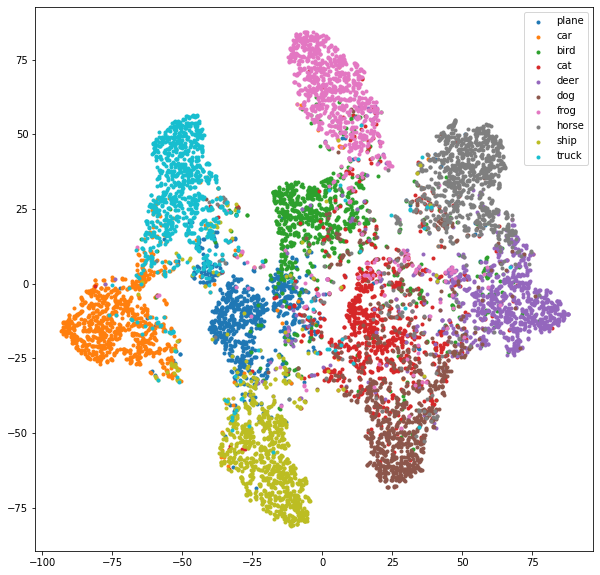

In [18]:
plt.figure(figsize=(10, 10))
cifar = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
'''
실제값을 0부터 9까지 차례대로 받아 for문이 한 번 돌 때마다 클래스 하나에 대한 데이터를 그리는 것입니다. 
그리고 cluster는 t-SNE의 결과값으로 2차원으로 차원 축소 된 좌표를 모아놓은 배열입니다. 
즉, 2개의 점 정보가 들어있는 것이고 0(0열)은 x좌표, 1(1열)은 y좌표가 됩니다.
'''
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

점들의 분포가 근접할수록 유사하다고 판단